In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as pl
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import os
import math 
from matplotlib.dates import MonthLocator, DateFormatter

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback

from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.regularizers import l2

import optuna


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def objective_GRU(trial):
    
    units_layer = trial.suggest_int('units_layer', 1, 200) # number of neurons
    learning_rate = trial.suggest_uniform('learning_rate',0.0001,0.1)
    batch_size = trial.suggest_categorical('batch_size',[4,8,16, 32, 64, 128, 256,512])
    # num_layers = trial.suggest_int('num_layers', 1, 2)
    dropout_rate = trial.suggest_float('dropout_rate_'+str(i+1),0,0.5,log=False)
    l2_reg = trial.suggest_float('l2_reg', 0, 0.1)

    
    model = Sequential([
                    layers.GRU(units=units_layer,input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),dropout=dropout_rate,kernel_regularizer=l2(l2_reg),return_sequences=False),
                    #layers.GRU(units=units_layer,dropout=dropout_rate,kernel_regularizer=l2(l2_reg),return_sequences=False),
                    layers.Dense(n_ahead)])

    # Assuming you have one output dimension, adjust accordingly
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])

    early_stopping_callback = EarlyStopping(
        monitor='val_loss',  # or another metric you want to monitor
        patience=30,  # number of epochs with no improvement after which training will be stopped
        mode='min',
        restore_best_weights=True,  # 'min' or 'max': minimize the quantity monitored or maximize it
        verbose=0  # 0: quiet, 1: update messages
    )
    model.fit(X_train_scaled, y_train, epochs=500,verbose=0,validation_data=(X_val_scaled,y_val),batch_size=batch_size, callbacks=[early_stopping_callback])
    
    test_predictions = model.predict(X_test_scaled)
    y_test_1 = y_test.reshape(len(y_test),-1)
    mae_per_column = np.mean(np.abs(y_test_1- test_predictions), axis=0)
    total_mae = sum(mae_per_column) / len(mae_per_column)

    # test_loss,mae = model.evaluate(X_test_scaled, y_test)

    return total_mae


# Many to Many

In [9]:
n_ahead=10
timesteps = 3

cwd = os.getcwd()
df_hist = pd.read_csv(cwd + '/datos_TFM_Celia.csv', sep = ',', engine='python')
df_hist['Time'] = pd.to_datetime(df_hist['Time'])
df_hist.set_index('Time',inplace=True)

for i in range(1, n_ahead+1):
    df_hist[f'ws_lead{i}'] = df_hist['ws'].shift(-i)
for i in range(1, n_ahead+1):
    df_hist[f'wd_lead{i}'] = df_hist['wd'].shift(-i)
df_hist.dropna(inplace=True)

INPUTS = ['Power','wd','ws'] + [f'ws_lead{i}' for i in range(1, n_ahead+1)]+ [f'wd_lead{i}' for i in range(1, n_ahead+1)]
OUTPUT = ['Power']

X_orig = df_hist[INPUTS]
y_orig = df_hist[OUTPUT]

n_features=X_orig.shape[1]

np_X=X_orig.to_numpy()
np_y=y_orig.to_numpy()
X=[]
y=[]

for i in range(len(np_X)-timesteps-n_ahead):
    row = [[a] for a in np_X[i:i+timesteps]]
    X.append(row)
    label = np_y[i+timesteps:i+timesteps+n_ahead]
    y.append(label)

X,y=np.array(X), np.array(y)
X=X.reshape(X.shape[0],timesteps,n_features)

q_30 = int(len(X) * .3)
q_50 = int(len(X) * .5)
X_train, y_train =  X[:q_30], y[:q_30]
X_val, y_val =  X[q_30:q_50], y[q_30:q_50]
X_test, y_test =  X[q_50:], y[q_50:]

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train.reshape(len(X_train),-1))
X_train_scaled = X_train_scaled.reshape(len(X_train),timesteps,n_features)

X_val_scaled = scaler.fit_transform(X_val.reshape(len(X_val),-1))
X_val_scaled = X_val_scaled.reshape(len(X_val),timesteps,n_features)

X_test_scaled = scaler.transform(X_test.reshape(len(X_test),-1))
X_test_scaled = X_test_scaled.reshape(len(X_test),timesteps,n_features)


### Optimizar hiperparámetros

In [10]:
study = optuna.create_study(direction='minimize')  # minimizing mean squared error
study.optimize(objective_GRU, n_trials=100) #trials=100
print(study.best_params)  

[I 2024-06-04 12:38:16,331] A new study created in memory with name: no-name-08714970-7bc3-405b-86d4-667f5e2e6a51
/var/folders/ck/11mmsnfs1pgczh62kv6s4stw0000gn/T/ipykernel_88796/795732745.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate',0.0001,0.1)


274/274 [==============================] - 0s 450us/step


[I 2024-06-04 12:38:22,336] Trial 0 finished with value: 0.13574145962017048 and parameters: {'units_layer': 55, 'learning_rate': 0.0050049193469305885, 'batch_size': 256, 'dropout_rate_17515': 0.4927295924119516, 'l2_reg': 0.0225968157143989}. Best is trial 0 with value: 0.13574145962017048.


274/274 [==============================] - 1s 1ms/step


[I 2024-06-04 12:39:36,522] Trial 1 finished with value: 0.1455701915238961 and parameters: {'units_layer': 127, 'learning_rate': 0.05017520322863322, 'batch_size': 4, 'dropout_rate_17515': 0.2507946787051604, 'l2_reg': 0.08218050012737549}. Best is trial 0 with value: 0.13574145962017048.


274/274 [==============================] - 0s 455us/step


[I 2024-06-04 12:40:01,366] Trial 2 finished with value: 0.14573376975062904 and parameters: {'units_layer': 63, 'learning_rate': 0.08791785624078748, 'batch_size': 8, 'dropout_rate_17515': 0.11100909034592804, 'l2_reg': 0.03811537753334309}. Best is trial 0 with value: 0.13574145962017048.


274/274 [==============================] - 0s 490us/step


[I 2024-06-04 12:40:09,781] Trial 3 finished with value: 0.1250443461372557 and parameters: {'units_layer': 79, 'learning_rate': 0.07548233654088182, 'batch_size': 512, 'dropout_rate_17515': 0.2123323648585499, 'l2_reg': 0.0005864663487903932}. Best is trial 3 with value: 0.1250443461372557.


274/274 [==============================] - 0s 736us/step


[I 2024-06-04 12:40:28,214] Trial 4 finished with value: 0.13889431987157766 and parameters: {'units_layer': 165, 'learning_rate': 0.007588838145304144, 'batch_size': 32, 'dropout_rate_17515': 0.473902185902531, 'l2_reg': 0.05403408317854901}. Best is trial 3 with value: 0.1250443461372557.


274/274 [==============================] - 1s 2ms/step


[I 2024-06-04 12:40:42,626] Trial 5 finished with value: 0.12386459246127564 and parameters: {'units_layer': 181, 'learning_rate': 0.007944732012550025, 'batch_size': 512, 'dropout_rate_17515': 0.19707991231627953, 'l2_reg': 0.06505863784181289}. Best is trial 5 with value: 0.12386459246127564.


274/274 [==============================] - 0s 434us/step


[I 2024-06-04 12:40:47,750] Trial 6 finished with value: 0.13180056125387543 and parameters: {'units_layer': 33, 'learning_rate': 0.02824505069228048, 'batch_size': 128, 'dropout_rate_17515': 0.3493074168779727, 'l2_reg': 0.09298183497690186}. Best is trial 5 with value: 0.12386459246127564.


274/274 [==============================] - 0s 711us/step


[I 2024-06-04 12:40:58,873] Trial 7 finished with value: 0.13158274326445601 and parameters: {'units_layer': 97, 'learning_rate': 0.02257689843506769, 'batch_size': 128, 'dropout_rate_17515': 0.3549307354783571, 'l2_reg': 0.0646670159366206}. Best is trial 5 with value: 0.12386459246127564.


274/274 [==============================] - 0s 433us/step


[I 2024-06-04 12:41:13,824] Trial 8 finished with value: 0.13657824924466402 and parameters: {'units_layer': 51, 'learning_rate': 0.052604894329377344, 'batch_size': 64, 'dropout_rate_17515': 0.48142244406788826, 'l2_reg': 0.09660648672078087}. Best is trial 5 with value: 0.12386459246127564.


274/274 [==============================] - 0s 507us/step


[I 2024-06-04 12:41:24,560] Trial 9 finished with value: 0.13111850761153457 and parameters: {'units_layer': 91, 'learning_rate': 0.05991415205304479, 'batch_size': 64, 'dropout_rate_17515': 0.14982229191902074, 'l2_reg': 0.08181405502279471}. Best is trial 5 with value: 0.12386459246127564.


274/274 [==============================] - 0s 740us/step


[I 2024-06-04 12:41:52,803] Trial 10 finished with value: 0.11619315059001059 and parameters: {'units_layer': 200, 'learning_rate': 0.03392445922596336, 'batch_size': 512, 'dropout_rate_17515': 0.016372757856043807, 'l2_reg': 0.06493525033997603}. Best is trial 10 with value: 0.11619315059001059.


274/274 [==============================] - 0s 864us/step


[I 2024-06-04 12:42:08,667] Trial 11 finished with value: 0.12039269855167571 and parameters: {'units_layer': 198, 'learning_rate': 0.029947114827800395, 'batch_size': 512, 'dropout_rate_17515': 0.02742377451792582, 'l2_reg': 0.068581155226597}. Best is trial 10 with value: 0.11619315059001059.


274/274 [==============================] - 0s 742us/step


[I 2024-06-04 12:42:36,505] Trial 12 finished with value: 0.11717024448518254 and parameters: {'units_layer': 200, 'learning_rate': 0.032414930515475456, 'batch_size': 512, 'dropout_rate_17515': 0.013044864310571946, 'l2_reg': 0.04430940351364519}. Best is trial 10 with value: 0.11619315059001059.


274/274 [==============================] - 0s 703us/step


[I 2024-06-04 12:43:06,989] Trial 13 finished with value: 0.1292800236292616 and parameters: {'units_layer': 144, 'learning_rate': 0.03712191657371014, 'batch_size': 16, 'dropout_rate_17515': 0.02683989071737939, 'l2_reg': 0.03995464034256446}. Best is trial 10 with value: 0.11619315059001059.


274/274 [==============================] - 0s 619us/step


[I 2024-06-04 12:43:31,758] Trial 14 finished with value: 0.11370887454950537 and parameters: {'units_layer': 133, 'learning_rate': 0.039870994189104274, 'batch_size': 512, 'dropout_rate_17515': 0.0025921690038023144, 'l2_reg': 0.02631740420300695}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 419us/step


[I 2024-06-04 12:43:35,786] Trial 15 finished with value: 0.1239049836407721 and parameters: {'units_layer': 3, 'learning_rate': 0.06768923084504948, 'batch_size': 512, 'dropout_rate_17515': 0.08020443430789484, 'l2_reg': 0.020478643297511506}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 615us/step


[I 2024-06-04 12:43:52,881] Trial 16 finished with value: 0.12126549982353733 and parameters: {'units_layer': 130, 'learning_rate': 0.041940015088177116, 'batch_size': 256, 'dropout_rate_17515': 0.08649779415372058, 'l2_reg': 0.02459462591100318}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 662us/step


[I 2024-06-04 12:44:59,636] Trial 17 finished with value: 0.1275151622784839 and parameters: {'units_layer': 157, 'learning_rate': 0.018904890391879817, 'batch_size': 8, 'dropout_rate_17515': 0.29707313864875373, 'l2_reg': 0.0018862151687328993}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 588us/step


[I 2024-06-04 12:45:14,295] Trial 18 finished with value: 0.12627340095507594 and parameters: {'units_layer': 116, 'learning_rate': 0.04354549990157327, 'batch_size': 32, 'dropout_rate_17515': 0.001187737607754518, 'l2_reg': 0.032018948367012634}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 706us/step


[I 2024-06-04 12:45:56,381] Trial 19 finished with value: 0.34950523218245005 and parameters: {'units_layer': 171, 'learning_rate': 0.08912516341192185, 'batch_size': 16, 'dropout_rate_17515': 0.13048576321026123, 'l2_reg': 0.05428271645032051}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 719us/step


[I 2024-06-04 12:47:45,088] Trial 20 finished with value: 0.12846494421781493 and parameters: {'units_layer': 149, 'learning_rate': 0.018381793114015166, 'batch_size': 4, 'dropout_rate_17515': 0.05816921277185433, 'l2_reg': 0.013057645272488781}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 786us/step


[I 2024-06-04 12:48:15,874] Trial 21 finished with value: 0.11633494871838534 and parameters: {'units_layer': 200, 'learning_rate': 0.035132214586287416, 'batch_size': 512, 'dropout_rate_17515': 0.003270850806288266, 'l2_reg': 0.04821953039162631}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 1s 1ms/step


[I 2024-06-04 12:48:31,149] Trial 22 finished with value: 0.17284317248634568 and parameters: {'units_layer': 192, 'learning_rate': 0.05738901203223554, 'batch_size': 512, 'dropout_rate_17515': 0.05642367911912317, 'l2_reg': 0.05287141598440132}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 1s 1ms/step


[I 2024-06-04 12:48:42,416] Trial 23 finished with value: 0.12938481445767644 and parameters: {'units_layer': 179, 'learning_rate': 0.04155173514427127, 'batch_size': 512, 'dropout_rate_17515': 0.15320453185170574, 'l2_reg': 0.029902460212275387}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 614us/step


[I 2024-06-04 12:48:58,949] Trial 24 finished with value: 0.11759511155852062 and parameters: {'units_layer': 115, 'learning_rate': 0.02406227177143024, 'batch_size': 512, 'dropout_rate_17515': 0.05192945903238065, 'l2_reg': 0.07504536710387455}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 731us/step


[I 2024-06-04 12:49:29,002] Trial 25 finished with value: 0.11664466585046929 and parameters: {'units_layer': 183, 'learning_rate': 0.035375617823810185, 'batch_size': 512, 'dropout_rate_17515': 0.0017154157189750927, 'l2_reg': 0.04482326497040866}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 659us/step


[I 2024-06-04 12:49:44,036] Trial 26 finished with value: 0.1255877839428274 and parameters: {'units_layer': 140, 'learning_rate': 0.046003423320763355, 'batch_size': 512, 'dropout_rate_17515': 0.11228969355021577, 'l2_reg': 0.05997197126054916}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 761us/step


[I 2024-06-04 12:49:56,216] Trial 27 finished with value: 0.12209738065870965 and parameters: {'units_layer': 163, 'learning_rate': 0.015503642278653983, 'batch_size': 512, 'dropout_rate_17515': 0.18655747230547, 'l2_reg': 0.013009206030809921}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 741us/step


[I 2024-06-04 12:50:07,761] Trial 28 finished with value: 0.19327331049921104 and parameters: {'units_layer': 187, 'learning_rate': 0.058091336010715436, 'batch_size': 128, 'dropout_rate_17515': 0.08096471594971896, 'l2_reg': 0.07350176707307321}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 799us/step


[I 2024-06-04 12:50:26,289] Trial 29 finished with value: 0.18142554913142625 and parameters: {'units_layer': 168, 'learning_rate': 0.0686566459151706, 'batch_size': 256, 'dropout_rate_17515': 0.4178247040564302, 'l2_reg': 0.04796495626297459}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 613us/step


[I 2024-06-04 12:51:25,692] Trial 30 finished with value: 0.13658155052992962 and parameters: {'units_layer': 113, 'learning_rate': 0.037392550263554265, 'batch_size': 8, 'dropout_rate_17515': 0.03425913686748254, 'l2_reg': 0.059332831800546354}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 700us/step


[I 2024-06-04 12:51:43,008] Trial 31 finished with value: 0.11556198345332365 and parameters: {'units_layer': 180, 'learning_rate': 0.03409362709958882, 'batch_size': 512, 'dropout_rate_17515': 0.001889575079649241, 'l2_reg': 0.04344634626624984}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 720us/step


[I 2024-06-04 12:52:01,434] Trial 32 finished with value: 0.11484059524564025 and parameters: {'units_layer': 199, 'learning_rate': 0.030578071418948003, 'batch_size': 512, 'dropout_rate_17515': 0.0012918987635111663, 'l2_reg': 0.03176244494272031}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 847us/step


[I 2024-06-04 12:53:09,833] Trial 33 finished with value: 0.13896715124487613 and parameters: {'units_layer': 154, 'learning_rate': 0.050999790256150805, 'batch_size': 4, 'dropout_rate_17515': 0.058692967738488616, 'l2_reg': 0.03385426499213585}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 717us/step


[I 2024-06-04 12:53:23,070] Trial 34 finished with value: 0.11874239741331513 and parameters: {'units_layer': 175, 'learning_rate': 0.013185653512725444, 'batch_size': 512, 'dropout_rate_17515': 0.10221129791551892, 'l2_reg': 0.024853562709588474}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 721us/step


[I 2024-06-04 12:53:54,226] Trial 35 finished with value: 0.12672599138671115 and parameters: {'units_layer': 188, 'learning_rate': 0.02466699026909086, 'batch_size': 32, 'dropout_rate_17515': 0.04334816991731589, 'l2_reg': 0.040278785159091245}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 616us/step


[I 2024-06-04 12:54:08,198] Trial 36 finished with value: 0.12461693365446806 and parameters: {'units_layer': 129, 'learning_rate': 0.027969109313188526, 'batch_size': 512, 'dropout_rate_17515': 0.2819943144062864, 'l2_reg': 0.016353116784880245}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 593us/step


[I 2024-06-04 12:54:19,900] Trial 37 finished with value: 0.12876646742718031 and parameters: {'units_layer': 83, 'learning_rate': 0.04898760699007727, 'batch_size': 64, 'dropout_rate_17515': 0.07698552068753019, 'l2_reg': 0.0366154219543355}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 674us/step


[I 2024-06-04 12:55:23,114] Trial 38 finished with value: 0.11784702685948116 and parameters: {'units_layer': 162, 'learning_rate': 0.010155210200345946, 'batch_size': 16, 'dropout_rate_17515': 0.03345110242978476, 'l2_reg': 0.028990310927542992}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 688us/step


[I 2024-06-04 12:55:33,782] Trial 39 finished with value: 0.1290455506035361 and parameters: {'units_layer': 137, 'learning_rate': 0.03983167697955539, 'batch_size': 256, 'dropout_rate_17515': 0.17040515252249638, 'l2_reg': 0.05677906113873328}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 451us/step


[I 2024-06-04 12:55:39,116] Trial 40 finished with value: 0.1243437935681205 and parameters: {'units_layer': 63, 'learning_rate': 0.005260089275950484, 'batch_size': 512, 'dropout_rate_17515': 0.2348700400480188, 'l2_reg': 0.0070250951068149825}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 847us/step


[I 2024-06-04 12:56:04,208] Trial 41 finished with value: 0.1161089277640868 and parameters: {'units_layer': 194, 'learning_rate': 0.032364458783190234, 'batch_size': 512, 'dropout_rate_17515': 0.009785169653005098, 'l2_reg': 0.04443422193446463}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 725us/step


[I 2024-06-04 12:56:23,946] Trial 42 finished with value: 0.11526056954099721 and parameters: {'units_layer': 191, 'learning_rate': 0.030808667388269567, 'batch_size': 512, 'dropout_rate_17515': 0.02278673808055909, 'l2_reg': 0.04341835752772416}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 727us/step


[I 2024-06-04 12:56:38,018] Trial 43 finished with value: 0.12087935680003792 and parameters: {'units_layer': 175, 'learning_rate': 0.027844688791631704, 'batch_size': 512, 'dropout_rate_17515': 0.11695653293631092, 'l2_reg': 0.04351593120899271}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 725us/step


[I 2024-06-04 12:56:55,314] Trial 44 finished with value: 0.11547393158432177 and parameters: {'units_layer': 190, 'learning_rate': 0.021577299972936767, 'batch_size': 512, 'dropout_rate_17515': 0.026880817649818, 'l2_reg': 0.03950625471977794}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 847us/step


[I 2024-06-04 12:57:48,513] Trial 45 finished with value: 0.11541516035119374 and parameters: {'units_layer': 184, 'learning_rate': 0.0007437008136247647, 'batch_size': 128, 'dropout_rate_17515': 0.03258041736008316, 'l2_reg': 0.036851017489676355}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 812us/step


[I 2024-06-04 12:58:24,876] Trial 46 finished with value: 0.11769086686601886 and parameters: {'units_layer': 186, 'learning_rate': 0.020914026391046774, 'batch_size': 128, 'dropout_rate_17515': 0.03442935955670238, 'l2_reg': 0.03474955449345776}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 813us/step


[I 2024-06-04 12:59:01,587] Trial 47 finished with value: 0.11912404646492905 and parameters: {'units_layer': 169, 'learning_rate': 0.0008831413608844338, 'batch_size': 128, 'dropout_rate_17515': 0.09585467551446374, 'l2_reg': 0.02766292328028217}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 479us/step


[I 2024-06-04 12:59:17,328] Trial 48 finished with value: 0.11726683439832675 and parameters: {'units_layer': 37, 'learning_rate': 0.0007643791528643348, 'batch_size': 128, 'dropout_rate_17515': 0.060333907755678665, 'l2_reg': 0.020434127605170386}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 754us/step


[I 2024-06-04 12:59:28,864] Trial 49 finished with value: 0.12139094439043496 and parameters: {'units_layer': 103, 'learning_rate': 0.011185554802903282, 'batch_size': 64, 'dropout_rate_17515': 0.13012035500430927, 'l2_reg': 0.03850541714818607}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 652us/step


[I 2024-06-04 13:00:20,291] Trial 50 finished with value: 0.15290928465203818 and parameters: {'units_layer': 150, 'learning_rate': 0.09737608867647146, 'batch_size': 8, 'dropout_rate_17515': 0.44717694048274537, 'l2_reg': 0.023198272392554745}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 800us/step


[I 2024-06-04 13:00:41,700] Trial 51 finished with value: 0.11652473999609425 and parameters: {'units_layer': 181, 'learning_rate': 0.029973134440885105, 'batch_size': 512, 'dropout_rate_17515': 0.02466998706764364, 'l2_reg': 0.040224278244570616}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 739us/step


[I 2024-06-04 13:02:33,930] Trial 52 finished with value: 0.1322048949537981 and parameters: {'units_layer': 193, 'learning_rate': 0.016244026207653563, 'batch_size': 4, 'dropout_rate_17515': 0.017421736950591207, 'l2_reg': 0.051821255346123266}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 714us/step


[I 2024-06-04 13:02:54,220] Trial 53 finished with value: 0.126642987371354 and parameters: {'units_layer': 177, 'learning_rate': 0.02376502297803185, 'batch_size': 32, 'dropout_rate_17515': 0.06511428455912084, 'l2_reg': 0.032161334610297465}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 681us/step


[I 2024-06-04 13:03:07,215] Trial 54 finished with value: 0.12617879270741733 and parameters: {'units_layer': 158, 'learning_rate': 0.04695753558328622, 'batch_size': 128, 'dropout_rate_17515': 0.03928084046543666, 'l2_reg': 0.049065493995227125}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 763us/step


[I 2024-06-04 13:03:32,851] Trial 55 finished with value: 0.11618437329192415 and parameters: {'units_layer': 200, 'learning_rate': 0.038982296116887236, 'batch_size': 512, 'dropout_rate_17515': 0.0020675606672024625, 'l2_reg': 0.03579212839077032}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 728us/step


[I 2024-06-04 13:03:47,791] Trial 56 finished with value: 0.11735919272813677 and parameters: {'units_layer': 191, 'learning_rate': 0.030905936378782667, 'batch_size': 512, 'dropout_rate_17515': 0.023478942925531543, 'l2_reg': 0.027711068910724463}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 760us/step


[I 2024-06-04 13:04:42,944] Trial 57 finished with value: 0.1357987646433484 and parameters: {'units_layer': 183, 'learning_rate': 0.04362486343110027, 'batch_size': 16, 'dropout_rate_17515': 0.07828787233662773, 'l2_reg': 0.04237245704994453}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 888us/step


[I 2024-06-04 13:04:56,481] Trial 58 finished with value: 0.12960879558538407 and parameters: {'units_layer': 172, 'learning_rate': 0.026417974882340208, 'batch_size': 512, 'dropout_rate_17515': 0.33388438504062934, 'l2_reg': 0.04605580851482043}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 739us/step


[I 2024-06-04 13:05:15,349] Trial 59 finished with value: 0.11624730756713468 and parameters: {'units_layer': 192, 'learning_rate': 0.007241071498413999, 'batch_size': 512, 'dropout_rate_17515': 0.05102878583047472, 'l2_reg': 0.017241852506388395}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 701us/step


[I 2024-06-04 13:05:41,614] Trial 60 finished with value: 0.11515413868481428 and parameters: {'units_layer': 165, 'learning_rate': 0.02094543877885846, 'batch_size': 128, 'dropout_rate_17515': 0.018083280637504695, 'l2_reg': 0.03775670896237296}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 735us/step


[I 2024-06-04 13:05:53,831] Trial 61 finished with value: 0.11662396386029623 and parameters: {'units_layer': 164, 'learning_rate': 0.020646432038941648, 'batch_size': 128, 'dropout_rate_17515': 0.01942225937350135, 'l2_reg': 0.031411948212481576}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 712us/step


[I 2024-06-04 13:06:06,137] Trial 62 finished with value: 0.12203990378252585 and parameters: {'units_layer': 179, 'learning_rate': 0.032966942987195894, 'batch_size': 128, 'dropout_rate_17515': 0.0026891618629491, 'l2_reg': 0.03817576135238328}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 815us/step


[I 2024-06-04 13:06:24,370] Trial 63 finished with value: 0.1185902862796124 and parameters: {'units_layer': 185, 'learning_rate': 0.016299019344008892, 'batch_size': 128, 'dropout_rate_17515': 0.037041916878850514, 'l2_reg': 0.0414666472812785}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 660us/step


[I 2024-06-04 13:06:40,010] Trial 64 finished with value: 0.11981310890093874 and parameters: {'units_layer': 149, 'learning_rate': 0.035881015638587824, 'batch_size': 256, 'dropout_rate_17515': 0.06668315903553976, 'l2_reg': 0.035085256206891076}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 1s 825us/step


[I 2024-06-04 13:07:00,195] Trial 65 finished with value: 0.11505446088910606 and parameters: {'units_layer': 195, 'learning_rate': 0.020123368927305645, 'batch_size': 512, 'dropout_rate_17515': 0.015040219909794253, 'l2_reg': 0.025140947371554298}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 613us/step


[I 2024-06-04 13:07:10,073] Trial 66 finished with value: 0.11791599549489598 and parameters: {'units_layer': 123, 'learning_rate': 0.01944799514201511, 'batch_size': 128, 'dropout_rate_17515': 0.04344031711270661, 'l2_reg': 0.026604812211736294}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 400us/step


[I 2024-06-04 13:08:04,810] Trial 67 finished with value: 0.13003763670790688 and parameters: {'units_layer': 4, 'learning_rate': 0.012800357362025241, 'batch_size': 8, 'dropout_rate_17515': 0.09518419161298203, 'l2_reg': 0.02116193656470486}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 869us/step


[I 2024-06-04 13:08:27,982] Trial 68 finished with value: 0.11408359611292769 and parameters: {'units_layer': 197, 'learning_rate': 0.023523098957612155, 'batch_size': 512, 'dropout_rate_17515': 0.017597554210775752, 'l2_reg': 0.030604273777479055}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 1s 1ms/step


[I 2024-06-04 13:09:54,791] Trial 69 finished with value: 0.1319601458891975 and parameters: {'units_layer': 197, 'learning_rate': 0.026005842954398235, 'batch_size': 4, 'dropout_rate_17515': 0.015210513715699463, 'l2_reg': 0.01745364717089789}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 882us/step


[I 2024-06-04 13:10:22,043] Trial 70 finished with value: 0.11649971352527429 and parameters: {'units_layer': 200, 'learning_rate': 0.004071503557299547, 'batch_size': 64, 'dropout_rate_17515': 0.0732786950054885, 'l2_reg': 0.011171072759071211}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 736us/step


[I 2024-06-04 13:10:38,706] Trial 71 finished with value: 0.11652252142112748 and parameters: {'units_layer': 191, 'learning_rate': 0.023711165219944152, 'batch_size': 512, 'dropout_rate_17515': 0.02502588325853983, 'l2_reg': 0.030339038860640013}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 738us/step


[I 2024-06-04 13:10:59,234] Trial 72 finished with value: 0.115927142652735 and parameters: {'units_layer': 188, 'learning_rate': 0.021575027529502393, 'batch_size': 512, 'dropout_rate_17515': 0.047779765839347225, 'l2_reg': 0.023949885152423744}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 771us/step


[I 2024-06-04 13:11:18,458] Trial 73 finished with value: 0.11533897275141405 and parameters: {'units_layer': 195, 'learning_rate': 0.01732233823842691, 'batch_size': 512, 'dropout_rate_17515': 0.01756180903567054, 'l2_reg': 0.033129270385979286}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 692us/step


[I 2024-06-04 13:11:33,789] Trial 74 finished with value: 0.11644991736457441 and parameters: {'units_layer': 171, 'learning_rate': 0.013922435096527245, 'batch_size': 512, 'dropout_rate_17515': 0.010747805595642403, 'l2_reg': 0.03257766595845736}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 925us/step


[I 2024-06-04 13:12:13,742] Trial 75 finished with value: 0.11777926057996972 and parameters: {'units_layer': 197, 'learning_rate': 0.017088649751267348, 'batch_size': 32, 'dropout_rate_17515': 0.050094591344963774, 'l2_reg': 0.025628720180328652}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 831us/step


[I 2024-06-04 13:12:36,801] Trial 76 finished with value: 0.11766584434109757 and parameters: {'units_layer': 183, 'learning_rate': 0.030246485097190814, 'batch_size': 512, 'dropout_rate_17515': 0.014754745807519664, 'l2_reg': 0.09156115722461687}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 696us/step


[I 2024-06-04 13:12:56,200] Trial 77 finished with value: 0.1310575749601237 and parameters: {'units_layer': 175, 'learning_rate': 0.00999280684058832, 'batch_size': 512, 'dropout_rate_17515': 0.38980712716574034, 'l2_reg': 0.036854800401156476}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 631us/step


[I 2024-06-04 13:13:14,008] Trial 78 finished with value: 0.11814753752255128 and parameters: {'units_layer': 139, 'learning_rate': 0.027072288977329387, 'batch_size': 512, 'dropout_rate_17515': 0.08843565733069163, 'l2_reg': 0.029645344013058524}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 794us/step


[I 2024-06-04 13:14:17,703] Trial 79 finished with value: 0.12676390875812962 and parameters: {'units_layer': 195, 'learning_rate': 0.039408627649420234, 'batch_size': 16, 'dropout_rate_17515': 0.0007258745271371825, 'l2_reg': 0.01909552400375519}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 1s 1ms/step


[I 2024-06-04 13:14:43,872] Trial 80 finished with value: 0.12263175473392651 and parameters: {'units_layer': 166, 'learning_rate': 0.006333250281607833, 'batch_size': 128, 'dropout_rate_17515': 0.2168716757211709, 'l2_reg': 0.04615833357744829}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 842us/step


[I 2024-06-04 13:15:00,823] Trial 81 finished with value: 0.1150722487907915 and parameters: {'units_layer': 187, 'learning_rate': 0.018535610804648595, 'batch_size': 512, 'dropout_rate_17515': 0.028959773384454515, 'l2_reg': 0.03429236523468175}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 775us/step


[I 2024-06-04 13:15:13,530] Trial 82 finished with value: 0.11609092671242423 and parameters: {'units_layer': 185, 'learning_rate': 0.018003932044284583, 'batch_size': 512, 'dropout_rate_17515': 0.03516969141622194, 'l2_reg': 0.033822998654770106}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 764us/step


[I 2024-06-04 13:15:30,794] Trial 83 finished with value: 0.11721265349337939 and parameters: {'units_layer': 195, 'learning_rate': 0.028876702300318014, 'batch_size': 512, 'dropout_rate_17515': 0.057971794532590666, 'l2_reg': 0.02874733821852985}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 728us/step


[I 2024-06-04 13:15:46,133] Trial 84 finished with value: 0.11511321806372388 and parameters: {'units_layer': 180, 'learning_rate': 0.014335742186454977, 'batch_size': 512, 'dropout_rate_17515': 0.025217468712430007, 'l2_reg': 0.03692127540100678}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 754us/step


[I 2024-06-04 13:16:00,706] Trial 85 finished with value: 0.11398793589114195 and parameters: {'units_layer': 156, 'learning_rate': 0.014276520049986191, 'batch_size': 512, 'dropout_rate_17515': 0.02050617067278022, 'l2_reg': 0.02213265286687418}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 833us/step


[I 2024-06-04 13:16:14,348] Trial 86 finished with value: 0.11585101181103238 and parameters: {'units_layer': 160, 'learning_rate': 0.014830593865569399, 'batch_size': 512, 'dropout_rate_17515': 0.04615696503768921, 'l2_reg': 0.015149682079129104}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 645us/step


[I 2024-06-04 13:16:30,883] Trial 87 finished with value: 0.11391486738241889 and parameters: {'units_layer': 152, 'learning_rate': 0.00990835408605531, 'batch_size': 512, 'dropout_rate_17515': 0.027571033472181473, 'l2_reg': 0.02232648291288551}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 662us/step


[I 2024-06-04 13:16:47,648] Trial 88 finished with value: 0.11628119610925003 and parameters: {'units_layer': 153, 'learning_rate': 0.00979545776455839, 'batch_size': 512, 'dropout_rate_17515': 0.07032238121308793, 'l2_reg': 0.01055898258908889}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 731us/step


[I 2024-06-04 13:17:00,925] Trial 89 finished with value: 0.12380752445505164 and parameters: {'units_layer': 157, 'learning_rate': 0.008364476543412862, 'batch_size': 512, 'dropout_rate_17515': 0.26513776464859806, 'l2_reg': 0.023033275333790074}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 650us/step


[I 2024-06-04 13:17:11,348] Trial 90 finished with value: 0.11740166122878874 and parameters: {'units_layer': 142, 'learning_rate': 0.013599112435585687, 'batch_size': 256, 'dropout_rate_17515': 0.031507613042525494, 'l2_reg': 0.021540262111061734}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 774us/step


[I 2024-06-04 13:17:29,047] Trial 91 finished with value: 0.1148398648164571 and parameters: {'units_layer': 173, 'learning_rate': 0.02234494503889255, 'batch_size': 512, 'dropout_rate_17515': 0.014716420549016241, 'l2_reg': 0.0265667207671037}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 675us/step


[I 2024-06-04 13:17:40,553] Trial 92 finished with value: 0.11488828822125734 and parameters: {'units_layer': 134, 'learning_rate': 0.02218111986707448, 'batch_size': 512, 'dropout_rate_17515': 0.013861960105041942, 'l2_reg': 0.025408720811339245}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 597us/step


[I 2024-06-04 13:17:55,966] Trial 93 finished with value: 0.11659768035600075 and parameters: {'units_layer': 121, 'learning_rate': 0.02542430777056081, 'batch_size': 512, 'dropout_rate_17515': 0.01276533345988516, 'l2_reg': 0.026468531996744975}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 698us/step


[I 2024-06-04 13:18:10,453] Trial 94 finished with value: 0.11507319111945283 and parameters: {'units_layer': 146, 'learning_rate': 0.012114079701452906, 'batch_size': 512, 'dropout_rate_17515': 0.0384499171301928, 'l2_reg': 0.019880626450117275}. Best is trial 14 with value: 0.11370887454950537.


274/274 [==============================] - 0s 847us/step


[I 2024-06-04 13:18:20,837] Trial 95 finished with value: 0.11741289781816663 and parameters: {'units_layer': 132, 'learning_rate': 0.022909397875270694, 'batch_size': 512, 'dropout_rate_17515': 0.044326175339183815, 'l2_reg': 0.019036232847058274}. Best is trial 14 with value: 0.11370887454950537.
[W 2024-06-04 13:18:22,585] Trial 96 failed with parameters: {'units_layer': 134, 'learning_rate': 0.01209935672639963, 'batch_size': 512, 'dropout_rate_17515': 0.001389931008719215, 'l2_reg': 0.015320155667219079} because of the following error: InvalidArgumentError().
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/ck/11mmsnfs1pgczh62kv6s4stw0000gn/T/ipykernel_88796/795732745.py", line 27, in objective_GRU
    model.fit(X_train_scaled, y_train, epochs=500,verbose=0,validation_data=(X_val_scaled,y_val),batch_size=b

InvalidArgumentError: Graph execution error:

Detected at node Adam/truediv_9 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/Users/celiagomezlimia/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/var/folders/ck/11mmsnfs1pgczh62kv6s4stw0000gn/T/ipykernel_88796/1260056068.py", line 2, in <module>

  File "/opt/homebrew/lib/python3.11/site-packages/optuna/study/study.py", line 451, in optimize

  File "/opt/homebrew/lib/python3.11/site-packages/optuna/study/_optimize.py", line 66, in _optimize

  File "/opt/homebrew/lib/python3.11/site-packages/optuna/study/_optimize.py", line 163, in _optimize_sequential

  File "/opt/homebrew/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial

  File "/var/folders/ck/11mmsnfs1pgczh62kv6s4stw0000gn/T/ipykernel_88796/795732745.py", line 27, in objective_GRU

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 544, in minimize

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1342, in apply_grad_to_update_var

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 241, in _update_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/adam.py", line 204, in update_step

Incompatible shapes: [0] vs. [10]
	 [[{{node Adam/truediv_9}}]] [Op:__inference_train_function_6474002]

In [11]:
print(study.best_params)  

{'units_layer': 133, 'learning_rate': 0.039870994189104274, 'batch_size': 512, 'dropout_rate_17515': 0.0025921690038023144, 'l2_reg': 0.02631740420300695}


### Entrenamiento

In [12]:
units_layer = 133
learning_rate = 0.039870994189104274
batch_size = 512
dropout_rate = 0.0025921690038023144
l2_reg = 0.02631740420300695

model = Sequential([
                    layers.GRU(units=units_layer,input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),dropout= dropout_rate, kernel_regularizer=l2(l2_reg), return_sequences=False),
                    layers.Dense(n_ahead)])
lr= learning_rate
model.compile(loss='mse', 
              optimizer=Adam(lr=lr),
              metrics=['mean_absolute_error'])

history=model.fit(X_train_scaled, y_train, epochs=1000,validation_data=(X_val_scaled,y_val),batch_size=batch_size)

# Compute baseline performance metric
baseline_loss = model.evaluate(X_val_scaled, y_val)[0]

Epoch 1/1000
11/11 [==============================] - 1s 39ms/step - loss: 1.0921 - mean_absolute_error: 0.2108 - val_loss: 0.9348 - val_mean_absolute_error: 0.2003
Epoch 2/1000
11/11 [==============================] - 0s 10ms/step - loss: 0.8238 - mean_absolute_error: 0.1745 - val_loss: 0.7051 - val_mean_absolute_error: 0.1725
Epoch 3/1000
11/11 [==============================] - 0s 12ms/step - loss: 0.6158 - mean_absolute_error: 0.1589 - val_loss: 0.5253 - val_mean_absolute_error: 0.1603
Epoch 4/1000
11/11 [==============================] - 0s 10ms/step - loss: 0.4555 - mean_absolute_error: 0.1478 - val_loss: 0.3874 - val_mean_absolute_error: 0.1517
Epoch 5/1000
11/11 [==============================] - 0s 11ms/step - loss: 0.3349 - mean_absolute_error: 0.1417 - val_loss: 0.2864 - val_mean_absolute_error: 0.1467
Epoch 6/1000
11/11 [==============================] - 0s 11ms/step - loss: 0.2461 - mean_absolute_error: 0.1370 - val_loss: 0.2129 - val_mean_absolute_error: 0.1441
Epoch 7/10

In [30]:
print("Número de parámetros ajustados en el modelo LSTM:", model.count_params())

Número de parámetros ajustados en el modelo LSTM: 64382


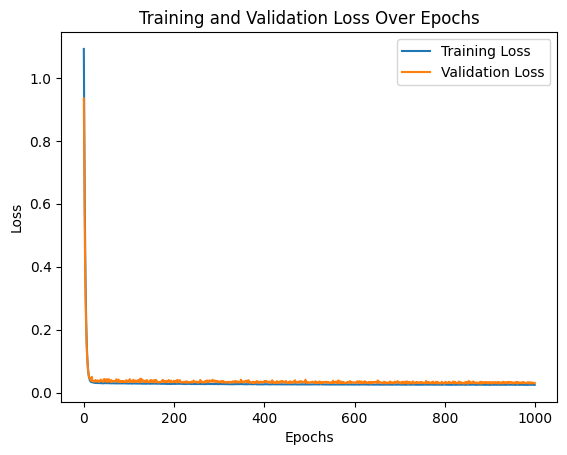

Epoch at Minimum Training Loss: 957
Minimum Training Loss: 0.024226203560829163
Epoch at Minimum Validation Loss: 798
Minimum Validation Loss: 0.028136396780610085


In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
min_loss_epoch = np.argmin(loss_values)
min_loss_value = loss_values[min_loss_epoch]
min_val_loss_epoch = np.argmin(val_loss_values)
min_val_loss_value = val_loss_values[min_val_loss_epoch]
print("Epoch at Minimum Training Loss:", min_loss_epoch)
print("Minimum Training Loss:", min_loss_value)
print("Epoch at Minimum Validation Loss:", min_val_loss_epoch)
print("Minimum Validation Loss:", min_val_loss_value)

### Prueba

In [14]:
test_predictions = model.predict(X_test_scaled)
y_test_1 = y_test.reshape(len(y_test),-1)
mae_per_column = np.mean(np.abs(y_test_1- test_predictions), axis=0)
list(mae_per_column) 

274/274 [==============================] - 0s 660us/step


[0.06523818835960421,
 0.09065166761215511,
 0.1060320979169024,
 0.1166733816023172,
 0.12428418439104515,
 0.13019926327134107,
 0.1347593415465583,
 0.1386757033380044,
 0.1425740670293789,
 0.14758503428977102]

In [15]:
column_names = [f"+{i+1}h" for i in range(n_ahead)]
df_test_preds = pd.DataFrame(test_predictions, columns=column_names)
df_test_preds.index = df_hist.index[q_50:-(timesteps+n_ahead)].values

In [17]:
test_preds_matrix = pd.DataFrame()

for i in range(n_ahead):
    shifted_predictions = df_test_preds.iloc[:, i].shift(i)
    test_preds_matrix[f'+{1+i}h'] = shifted_predictions

test_preds_matrix.index = df_test_preds.index
test_preds_matrix['Power'] = y_test[:, 0, 0]


In [18]:
df_resultados = test_preds_matrix.dropna()
error_list = []

for i in range(1, n_ahead+1):
    column_name = f'+{i}h'
    mae_a = mean_absolute_error(df_resultados['Power'], df_resultados[column_name])
    rmse_a = math.sqrt(mean_squared_error(df_resultados['Power'], df_resultados[column_name]))
    
    error_list.append({'Horizon': i, 'MAE ': mae_a, 'RMSE ': rmse_a})

# Convertir la lista de diccionarios a DataFrame
df_GRU_many_error = pd.DataFrame(error_list)
df_GRU_many_error

Horizon      MAE      RMSE 
0        1  0.065278  0.096180
1        2  0.090712  0.130255
2        3  0.106102  0.149985
3        4  0.116752  0.163077
4        5  0.124365  0.172679
5        6  0.130290  0.180208
6        7  0.134851  0.185536
7        8  0.138766  0.189586
8        9  0.142660  0.192522
9       10  0.147672  0.197261

In [11]:
df_GRU_many_error.to_csv('GRU_many_Resultados.csv', index=False)

In [12]:
horizonte_prediccion = 1
column_name = f'+{horizonte_prediccion}h'

df_plot = pd.DataFrame()
df_plot['Time'] = df_resultados.index
df_plot['Prediction'] = df_resultados[column_name].values
df_plot['Power'] = df_resultados['Power'].values

fig = pl.line(df_plot, x='Time', y=['Power', 'Prediction'])
fig.show()

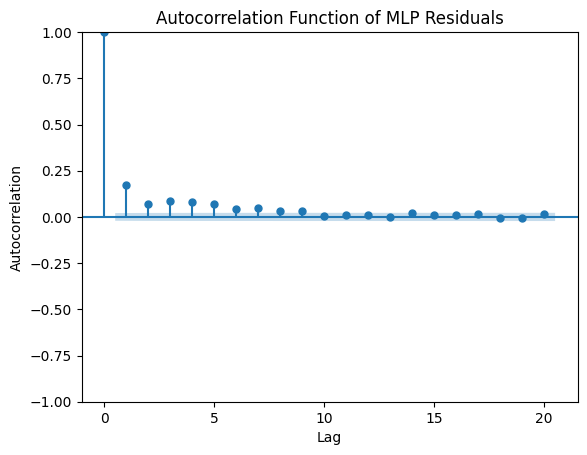

In [13]:
# Obtener residuos del modelo MLP
residuals = df_plot['Power'] - df_plot['Prediction']

# Calcular la función de autocorrelación de los residuos
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function of MLP Residuals')
plt.show()

# Many to One

In [28]:
timesteps=3
n_ahead = 1 # tamaño salida GRU (no cambiar)

#{'units_layer': 86, 'learning_rate': 0.0018091905426846529, 'batch_size': 512, 'dropout_rate_17533': 0.0010214250506347597, 'l2_reg': 0.008143628651399516}
# {'units_layer': 54, 'learning_rate': 0.006441443101734285, 'batch_size': 256, 'dropout_rate_17521': 0.036311759972368234, 'l2_reg': 0.0002566703952672309}
units_layer= 54
learning_rate = 0.006441443101734285
batch_size = 256
dropout_rate = 0.036311759972368234
l2_reg = 0.0002566703952672309

def prediccion(horizonte):
    cwd = os.getcwd()
    data = pd.read_csv(cwd + '/datos_TFM_Celia.csv', sep = ',', engine='python')
    data['Time'] = pd.to_datetime(data['Time'])

    data[f'ws_lead{horizonte}'] = data['ws'].shift(-horizonte)
    data[f'wd_lead{horizonte}'] = data['wd'].shift(-horizonte) #añadir dos leads más como en MLP?

    data.dropna(inplace=True)

    INPUTS = ['Power','ws','wd'] + [f'ws_lead{horizonte}'] + [f'wd_lead{horizonte}']
    OUTPUT = ['Power']

    X_orig = data[INPUTS]
    y_orig = data[OUTPUT]

    n_features=X_orig.shape[1]

    np_X=X_orig.to_numpy()
    np_y=y_orig.to_numpy()
    X=[]
    y=[]

    for i in range(len(np_X)-timesteps-horizonte+1):
        row = [[a] for a in np_X[i:i+timesteps]]
        X.append(row)
        label = np_y[i+timesteps+horizonte-1:i+timesteps+horizonte] #salida de tamaño 1, solo el horizonte
        y.append(label)

    X,y=np.array(X), np.array(y)
    X=X.reshape(X.shape[0],timesteps,n_features)

    q_30 = int(len(X) * .3)
    q_50 = int(len(X) * .5)
    X_train, y_train =  X[:q_30], y[:q_30]
    X_val, y_val =  X[q_30:q_50], y[q_30:q_50]
    X_test, y_test =  X[q_50:], y[q_50:]

    scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train.reshape(len(X_train),-1))
    X_train_scaled = X_train_scaled.reshape(len(X_train),timesteps,n_features)

    X_val_scaled = scaler.fit_transform(X_val.reshape(len(X_val),-1))
    X_val_scaled = X_val_scaled.reshape(len(X_val),timesteps,n_features)

    X_test_scaled = scaler.transform(X_test.reshape(len(X_test),-1))
    X_test_scaled = X_test_scaled.reshape(len(X_test),timesteps,n_features)

    model = Sequential([
                        layers.GRU(units=units_layer,input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),dropout= dropout_rate, kernel_regularizer=l2(l2_reg), return_sequences=False),
                        #layers.GRU(units=units_layer,dropout= dropout_rate, kernel_regularizer=l2(l2_reg), return_sequences=False),
                        layers.Dense(n_ahead)])

    model.compile(loss='mse', 
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['mean_absolute_error'])

    history=model.fit(X_train_scaled, y_train, epochs=500,validation_data=(X_val_scaled,y_val),batch_size=batch_size)

    baseline_loss = model.evaluate(X_val_scaled, y_val)[0] 

    test_predictions = model.predict(X_test_scaled)

    df_test = data.iloc[timesteps+horizonte-1:][q_50:][['Time','Power']].copy()

    column_names = [f"horizonte {horizonte}"]
    df_test[column_names] = test_predictions

    mae = mean_absolute_error(df_test['Power'], df_test[f"horizonte {horizonte}"])
    rmse = math.sqrt(mean_squared_error(df_test['Power'], df_test[f"horizonte {horizonte}"]))
    df_GRU_one_error.loc[f'horizonte {horizonte}h'] = [mae, rmse]

    print("Número de parámetros ajustados en el modelo LSTM:", model.count_params())


    return df_test

### Optimizar hiperparámetros

In [40]:
horizonte = 5

np_X=X_orig.to_numpy()
np_y=y_orig.to_numpy()
X=[]
y=[]

for i in range(len(np_X)-timesteps-horizonte+1):
    row = [[a] for a in np_X[i:i+timesteps]]
    X.append(row)
    label = np_y[i+timesteps+horizonte-1:i+timesteps+horizonte] #salida de tamaño 1, solo el horizonte
    y.append(label)

X,y=np.array(X), np.array(y)
X=X.reshape(X.shape[0],timesteps,n_features)

q_30 = int(len(X) * .3)
q_50 = int(len(X) * .5)
X_train, y_train =  X[:q_30], y[:q_30]
X_val, y_val =  X[q_30:q_50], y[q_30:q_50]
X_test, y_test =  X[q_50:], y[q_50:]

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train.reshape(len(X_train),-1))
X_train_scaled = X_train_scaled.reshape(len(X_train),timesteps,n_features)

X_val_scaled = scaler.fit_transform(X_val.reshape(len(X_val),-1))
X_val_scaled = X_val_scaled.reshape(len(X_val),timesteps,n_features)

X_test_scaled = scaler.transform(X_test.reshape(len(X_test),-1))
X_test_scaled = X_test_scaled.reshape(len(X_test),timesteps,n_features)

study = optuna.create_study(direction='minimize')  # minimizing mean squared error
study.optimize(objective_GRU, n_trials=100) 
print(study.best_params)   

[I 2024-06-02 13:10:57,716] A new study created in memory with name: no-name-4e72a62c-e2a6-46a3-a06f-89c51f08bd97
/var/folders/ck/11mmsnfs1pgczh62kv6s4stw0000gn/T/ipykernel_60403/795732745.py:4: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



274/274 [==============================] - 0s 803us/step


[I 2024-06-02 13:12:07,617] Trial 0 finished with value: 0.13210251106288592 and parameters: {'units_layer': 191, 'learning_rate': 0.052593463665297935, 'batch_size': 16, 'dropout_rate_17521': 0.011687412751520465, 'l2_reg': 0.0967710021496979}. Best is trial 0 with value: 0.13210251106288592.


274/274 [==============================] - 0s 782us/step


[I 2024-06-02 13:12:21,572] Trial 1 finished with value: 0.12658907551405735 and parameters: {'units_layer': 192, 'learning_rate': 0.061582765355933676, 'batch_size': 128, 'dropout_rate_17521': 0.040284375026986396, 'l2_reg': 0.07042535390293563}. Best is trial 1 with value: 0.12658907551405735.


274/274 [==============================] - 0s 572us/step


[I 2024-06-02 13:12:27,812] Trial 2 finished with value: 0.13783231936755794 and parameters: {'units_layer': 90, 'learning_rate': 0.0872772459982157, 'batch_size': 256, 'dropout_rate_17521': 0.4173798681353185, 'l2_reg': 0.033123998560870595}. Best is trial 1 with value: 0.12658907551405735.


274/274 [==============================] - 0s 434us/step


[I 2024-06-02 13:12:36,151] Trial 3 finished with value: 0.13229321100917474 and parameters: {'units_layer': 11, 'learning_rate': 0.054479168321906274, 'batch_size': 64, 'dropout_rate_17521': 0.4398774656765311, 'l2_reg': 0.04937950852224785}. Best is trial 1 with value: 0.12658907551405735.


274/274 [==============================] - 0s 505us/step


[I 2024-06-02 13:12:48,659] Trial 4 finished with value: 0.12474893504281546 and parameters: {'units_layer': 80, 'learning_rate': 0.07450635296228311, 'batch_size': 32, 'dropout_rate_17521': 0.037494074480475315, 'l2_reg': 0.014942236233560691}. Best is trial 4 with value: 0.12474893504281546.


274/274 [==============================] - 0s 457us/step


[I 2024-06-02 13:13:08,763] Trial 5 finished with value: 0.12898046441202707 and parameters: {'units_layer': 38, 'learning_rate': 0.04423009079216936, 'batch_size': 16, 'dropout_rate_17521': 0.38390579709475775, 'l2_reg': 0.002107592581613782}. Best is trial 4 with value: 0.12474893504281546.


274/274 [==============================] - 0s 511us/step


[I 2024-06-02 13:13:23,993] Trial 6 finished with value: 0.12641043513107283 and parameters: {'units_layer': 79, 'learning_rate': 0.03734277124946668, 'batch_size': 32, 'dropout_rate_17521': 0.3080943787983975, 'l2_reg': 0.0017973258149921346}. Best is trial 4 with value: 0.12474893504281546.


274/274 [==============================] - 0s 753us/step


[I 2024-06-02 13:13:35,544] Trial 7 finished with value: 0.12647000147726434 and parameters: {'units_layer': 160, 'learning_rate': 0.01869502565788914, 'batch_size': 256, 'dropout_rate_17521': 0.4262753816587015, 'l2_reg': 0.05790436657033865}. Best is trial 4 with value: 0.12474893504281546.


274/274 [==============================] - 0s 636us/step


[I 2024-06-02 13:14:00,631] Trial 8 finished with value: 0.14784659458883043 and parameters: {'units_layer': 141, 'learning_rate': 0.07682511085590742, 'batch_size': 32, 'dropout_rate_17521': 0.09877049455048414, 'l2_reg': 0.07016085227009716}. Best is trial 4 with value: 0.12474893504281546.


274/274 [==============================] - 0s 426us/step


[I 2024-06-02 13:14:12,441] Trial 9 finished with value: 0.12148608669754994 and parameters: {'units_layer': 38, 'learning_rate': 0.05985007724193613, 'batch_size': 32, 'dropout_rate_17521': 0.1889436744683769, 'l2_reg': 0.005847951445593913}. Best is trial 9 with value: 0.12148608669754994.


274/274 [==============================] - 0s 412us/step


[I 2024-06-02 13:14:19,285] Trial 10 finished with value: 0.12267985932326522 and parameters: {'units_layer': 41, 'learning_rate': 0.006338592694497151, 'batch_size': 512, 'dropout_rate_17521': 0.18400400242151677, 'l2_reg': 0.02724664499001079}. Best is trial 9 with value: 0.12148608669754994.


274/274 [==============================] - 0s 417us/step


[I 2024-06-02 13:14:27,118] Trial 11 finished with value: 0.12347062915603062 and parameters: {'units_layer': 37, 'learning_rate': 0.010057157706452949, 'batch_size': 512, 'dropout_rate_17521': 0.19093142654665718, 'l2_reg': 0.02828519040860312}. Best is trial 9 with value: 0.12148608669754994.


274/274 [==============================] - 0s 447us/step


[I 2024-06-02 13:16:11,583] Trial 12 finished with value: 0.12619933082936388 and parameters: {'units_layer': 49, 'learning_rate': 0.026640456897063642, 'batch_size': 4, 'dropout_rate_17521': 0.17705879576239586, 'l2_reg': 0.028780863491356147}. Best is trial 9 with value: 0.12148608669754994.


274/274 [==============================] - 0s 382us/step


[I 2024-06-02 13:16:15,275] Trial 13 finished with value: 0.1257766883644131 and parameters: {'units_layer': 3, 'learning_rate': 0.03269567482372031, 'batch_size': 512, 'dropout_rate_17521': 0.2636776682082548, 'l2_reg': 0.013811533530772538}. Best is trial 9 with value: 0.12148608669754994.


274/274 [==============================] - 0s 602us/step


[I 2024-06-02 13:17:06,544] Trial 14 finished with value: 0.19186068620617067 and parameters: {'units_layer': 119, 'learning_rate': 0.09668990851285597, 'batch_size': 8, 'dropout_rate_17521': 0.15032709775377057, 'l2_reg': 0.04298525961280761}. Best is trial 9 with value: 0.12148608669754994.


274/274 [==============================] - 0s 695us/step


[I 2024-06-02 13:17:19,246] Trial 15 finished with value: 0.13459831014630363 and parameters: {'units_layer': 62, 'learning_rate': 0.00042902665800882006, 'batch_size': 512, 'dropout_rate_17521': 0.3251474460197308, 'l2_reg': 0.017022109537756354}. Best is trial 9 with value: 0.12148608669754994.


274/274 [==============================] - 0s 410us/step


[I 2024-06-02 13:17:40,105] Trial 16 finished with value: 0.12517910376925911 and parameters: {'units_layer': 23, 'learning_rate': 0.06635034271181797, 'batch_size': 8, 'dropout_rate_17521': 0.22906790124778587, 'l2_reg': 0.019945360799010093}. Best is trial 9 with value: 0.12148608669754994.


274/274 [==============================] - 0s 503us/step


[I 2024-06-02 13:18:51,779] Trial 17 finished with value: 0.12282427915167583 and parameters: {'units_layer': 62, 'learning_rate': 0.019104231672069434, 'batch_size': 4, 'dropout_rate_17521': 0.11778514245223928, 'l2_reg': 0.00447846294406553}. Best is trial 9 with value: 0.12148608669754994.


274/274 [==============================] - 0s 630us/step


[I 2024-06-02 13:19:10,432] Trial 18 finished with value: 0.12788904355519767 and parameters: {'units_layer': 114, 'learning_rate': 0.044683849727127065, 'batch_size': 64, 'dropout_rate_17521': 0.24194724333243148, 'l2_reg': 0.03675923892780064}. Best is trial 9 with value: 0.12148608669754994.


274/274 [==============================] - 0s 417us/step


[I 2024-06-02 13:19:16,790] Trial 19 finished with value: 0.12079203664647307 and parameters: {'units_layer': 26, 'learning_rate': 0.0027429414333220298, 'batch_size': 128, 'dropout_rate_17521': 0.08667578139767199, 'l2_reg': 0.02220528955690947}. Best is trial 19 with value: 0.12079203664647307.


274/274 [==============================] - 0s 437us/step


[I 2024-06-02 13:19:21,942] Trial 20 finished with value: 0.12638728056171797 and parameters: {'units_layer': 22, 'learning_rate': 0.0650388976944486, 'batch_size': 128, 'dropout_rate_17521': 0.09413995859627652, 'l2_reg': 0.09472391823766418}. Best is trial 19 with value: 0.12079203664647307.


274/274 [==============================] - 0s 499us/step


[I 2024-06-02 13:19:38,478] Trial 21 finished with value: 0.12445495049665242 and parameters: {'units_layer': 52, 'learning_rate': 0.0005686326481323055, 'batch_size': 128, 'dropout_rate_17521': 0.14488421378073718, 'l2_reg': 0.023540485124051415}. Best is trial 19 with value: 0.12079203664647307.


274/274 [==============================] - 0s 419us/step


[I 2024-06-02 13:19:57,815] Trial 22 finished with value: 0.12231755232862554 and parameters: {'units_layer': 29, 'learning_rate': 0.009008046521033798, 'batch_size': 32, 'dropout_rate_17521': 0.19721434910681665, 'l2_reg': 0.009146273631776114}. Best is trial 19 with value: 0.12079203664647307.


274/274 [==============================] - 0s 408us/step


[I 2024-06-02 13:20:08,482] Trial 23 finished with value: 0.11961184081154617 and parameters: {'units_layer': 21, 'learning_rate': 0.0213364128795219, 'batch_size': 32, 'dropout_rate_17521': 0.058509278500916626, 'l2_reg': 0.009871730724895323}. Best is trial 23 with value: 0.11961184081154617.


274/274 [==============================] - 0s 419us/step


[I 2024-06-02 13:20:19,889] Trial 24 finished with value: 0.12006051755472218 and parameters: {'units_layer': 13, 'learning_rate': 0.019371158124020245, 'batch_size': 32, 'dropout_rate_17521': 0.058906301023467, 'l2_reg': 0.009289126731486796}. Best is trial 23 with value: 0.11961184081154617.


274/274 [==============================] - 0s 448us/step


[I 2024-06-02 13:20:28,386] Trial 25 finished with value: 0.11998163154223468 and parameters: {'units_layer': 2, 'learning_rate': 0.020026219901965275, 'batch_size': 128, 'dropout_rate_17521': 0.06524099603884657, 'l2_reg': 0.013027774810233095}. Best is trial 23 with value: 0.11961184081154617.


274/274 [==============================] - 0s 441us/step


[I 2024-06-02 13:20:40,647] Trial 26 finished with value: 0.1185776239436302 and parameters: {'units_layer': 5, 'learning_rate': 0.01784046607012657, 'batch_size': 32, 'dropout_rate_17521': 0.00010303939210076773, 'l2_reg': 0.011404675903400677}. Best is trial 26 with value: 0.1185776239436302.


274/274 [==============================] - 0s 404us/step


[I 2024-06-02 13:20:56,891] Trial 27 finished with value: 0.1221081616825757 and parameters: {'units_layer': 14, 'learning_rate': 0.02798310593412302, 'batch_size': 32, 'dropout_rate_17521': 0.0013586858604464902, 'l2_reg': 0.03625551733228671}. Best is trial 26 with value: 0.1185776239436302.


274/274 [==============================] - 0s 708us/step


[I 2024-06-02 13:21:02,499] Trial 28 finished with value: 0.12988553289615612 and parameters: {'units_layer': 1, 'learning_rate': 0.015076000251649433, 'batch_size': 128, 'dropout_rate_17521': 0.49162717034971, 'l2_reg': 0.011844780301281641}. Best is trial 26 with value: 0.1185776239436302.


274/274 [==============================] - 0s 481us/step


[I 2024-06-02 13:21:35,491] Trial 29 finished with value: 0.12093464495583861 and parameters: {'units_layer': 2, 'learning_rate': 0.025671199043249472, 'batch_size': 16, 'dropout_rate_17521': 0.0015936505971299111, 'l2_reg': 0.044442940840465024}. Best is trial 26 with value: 0.1185776239436302.


274/274 [==============================] - 0s 542us/step


[I 2024-06-02 13:21:55,185] Trial 30 finished with value: 0.12131246084050416 and parameters: {'units_layer': 63, 'learning_rate': 0.03291224056211631, 'batch_size': 32, 'dropout_rate_17521': 0.06032406425627301, 'l2_reg': 0.09036756971989923}. Best is trial 26 with value: 0.1185776239436302.


274/274 [==============================] - 0s 409us/step


[I 2024-06-02 13:22:09,503] Trial 31 finished with value: 0.11943711313547246 and parameters: {'units_layer': 15, 'learning_rate': 0.015768565545625845, 'batch_size': 32, 'dropout_rate_17521': 0.05814729258080225, 'l2_reg': 0.009983601073033142}. Best is trial 26 with value: 0.1185776239436302.


274/274 [==============================] - 0s 413us/step


[I 2024-06-02 13:22:22,945] Trial 32 finished with value: 0.11697229810803964 and parameters: {'units_layer': 18, 'learning_rate': 0.013371126367888156, 'batch_size': 32, 'dropout_rate_17521': 0.04267946884589229, 'l2_reg': 8.276417233982723e-05}. Best is trial 32 with value: 0.11697229810803964.


274/274 [==============================] - 0s 416us/step


[I 2024-06-02 13:22:43,166] Trial 33 finished with value: 0.11937227150774472 and parameters: {'units_layer': 19, 'learning_rate': 0.013844826805019347, 'batch_size': 32, 'dropout_rate_17521': 0.030412027764246508, 'l2_reg': 0.0028439382419559647}. Best is trial 32 with value: 0.11697229810803964.


274/274 [==============================] - 0s 455us/step


[I 2024-06-02 13:23:07,030] Trial 34 finished with value: 0.11619961595786464 and parameters: {'units_layer': 48, 'learning_rate': 0.011358917203833734, 'batch_size': 32, 'dropout_rate_17521': 0.026234324665074832, 'l2_reg': 0.00041485186965494435}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 438us/step


[I 2024-06-02 13:23:22,702] Trial 35 finished with value: 0.11742020427116287 and parameters: {'units_layer': 50, 'learning_rate': 0.01078293266108648, 'batch_size': 32, 'dropout_rate_17521': 0.020693109429480275, 'l2_reg': 5.216148734651493e-06}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 485us/step


[I 2024-06-02 13:23:37,926] Trial 36 finished with value: 0.11775180827351299 and parameters: {'units_layer': 76, 'learning_rate': 0.00898297863481324, 'batch_size': 256, 'dropout_rate_17521': 0.022350754978018757, 'l2_reg': 0.0008044337277643132}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 507us/step


[I 2024-06-02 13:23:48,527] Trial 37 finished with value: 0.11923247975575453 and parameters: {'units_layer': 78, 'learning_rate': 0.00970557006551072, 'batch_size': 256, 'dropout_rate_17521': 0.12597249201404417, 'l2_reg': 0.0005874551157570432}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 820us/step


[I 2024-06-02 13:24:03,933] Trial 38 finished with value: 0.11684541141413833 and parameters: {'units_layer': 99, 'learning_rate': 0.005028815473433422, 'batch_size': 64, 'dropout_rate_17521': 0.030786666405658636, 'l2_reg': 0.0007081261864460088}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 757us/step


[I 2024-06-02 13:24:25,267] Trial 39 finished with value: 0.12104178483198351 and parameters: {'units_layer': 98, 'learning_rate': 0.0408062846029954, 'batch_size': 64, 'dropout_rate_17521': 0.03531668439449823, 'l2_reg': 0.060987302755047545}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 905us/step


[I 2024-06-02 13:24:57,411] Trial 40 finished with value: 0.1207655285896038 and parameters: {'units_layer': 157, 'learning_rate': 0.005787281447692256, 'batch_size': 64, 'dropout_rate_17521': 0.08598455469829021, 'l2_reg': 0.08513172609615428}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 491us/step


[I 2024-06-02 13:25:09,105] Trial 41 finished with value: 0.11719789188000565 and parameters: {'units_layer': 88, 'learning_rate': 0.01127206569880442, 'batch_size': 256, 'dropout_rate_17521': 0.026996897526514158, 'l2_reg': 0.0013228170568718343}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 505us/step


[I 2024-06-02 13:25:19,277] Trial 42 finished with value: 0.11815653052298129 and parameters: {'units_layer': 90, 'learning_rate': 0.012897613270577946, 'batch_size': 256, 'dropout_rate_17521': 0.029887528711156762, 'l2_reg': 0.005514233179268793}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 1s 1ms/step


[I 2024-06-02 13:25:45,114] Trial 43 finished with value: 0.1193796670896674 and parameters: {'units_layer': 122, 'learning_rate': 0.004837679625637714, 'batch_size': 64, 'dropout_rate_17521': 0.10929322862204782, 'l2_reg': 0.01719358554797714}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 938us/step


[I 2024-06-02 13:26:13,652] Trial 44 finished with value: 0.11955491544251409 and parameters: {'units_layer': 102, 'learning_rate': 0.02290322548626582, 'batch_size': 16, 'dropout_rate_17521': 0.04480583750452191, 'l2_reg': 0.00018697046772676385}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 521us/step


[I 2024-06-02 13:26:20,053] Trial 45 finished with value: 0.12036699565452676 and parameters: {'units_layer': 47, 'learning_rate': 0.0316297508718353, 'batch_size': 256, 'dropout_rate_17521': 0.077438879823858, 'l2_reg': 0.006646525431211883}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 702us/step


[I 2024-06-02 13:26:37,823] Trial 46 finished with value: 0.1180351476731278 and parameters: {'units_layer': 68, 'learning_rate': 0.05263811979214865, 'batch_size': 64, 'dropout_rate_17521': 0.017317110641146116, 'l2_reg': 0.006106736254634821}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 660us/step


[I 2024-06-02 13:28:03,782] Trial 47 finished with value: 0.11998312133329513 and parameters: {'units_layer': 103, 'learning_rate': 0.01117219685194982, 'batch_size': 4, 'dropout_rate_17521': 0.0436700447396096, 'l2_reg': 0.016916598976657978}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 696us/step


[I 2024-06-02 13:28:51,329] Trial 48 finished with value: 0.1212611631736181 and parameters: {'units_layer': 133, 'learning_rate': 0.0054879736506255146, 'batch_size': 8, 'dropout_rate_17521': 0.13931648176007133, 'l2_reg': 1.0472244659900931e-05}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 517us/step


[I 2024-06-02 13:29:08,901] Trial 49 finished with value: 0.12901656210925933 and parameters: {'units_layer': 91, 'learning_rate': 0.023830660986996995, 'batch_size': 32, 'dropout_rate_17521': 0.34231895365274967, 'l2_reg': 0.02511798597326989}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 548us/step


[I 2024-06-02 13:29:17,155] Trial 50 finished with value: 0.12427663678946443 and parameters: {'units_layer': 54, 'learning_rate': 0.08366613825083541, 'batch_size': 256, 'dropout_rate_17521': 0.01927348920855589, 'l2_reg': 0.019215347062732216}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 468us/step


[I 2024-06-02 13:29:29,908] Trial 51 finished with value: 0.11757252054047063 and parameters: {'units_layer': 73, 'learning_rate': 0.007584571992332345, 'batch_size': 256, 'dropout_rate_17521': 0.023788225622377833, 'l2_reg': 0.0046032115116512035}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 519us/step


[I 2024-06-02 13:29:40,479] Trial 52 finished with value: 0.1184514231620038 and parameters: {'units_layer': 87, 'learning_rate': 0.007093078842306458, 'batch_size': 256, 'dropout_rate_17521': 0.0774414134049419, 'l2_reg': 0.0067413369534358196}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 903us/step


[I 2024-06-02 13:29:57,271] Trial 53 finished with value: 0.11824082368539918 and parameters: {'units_layer': 197, 'learning_rate': 0.01275777432263704, 'batch_size': 256, 'dropout_rate_17521': 0.03390196823732543, 'l2_reg': 0.004298649123320519}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 441us/step


[I 2024-06-02 13:30:09,567] Trial 54 finished with value: 0.12324886843199634 and parameters: {'units_layer': 34, 'learning_rate': 0.0007098158323050174, 'batch_size': 256, 'dropout_rate_17521': 0.10837148201440794, 'l2_reg': 0.014235699078183672}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 448us/step


[I 2024-06-02 13:30:34,173] Trial 55 finished with value: 0.12493334751973674 and parameters: {'units_layer': 57, 'learning_rate': 0.01564428768774991, 'batch_size': 32, 'dropout_rate_17521': 0.28409600567572263, 'l2_reg': 0.0034435139116783487}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 494us/step


[I 2024-06-02 13:30:54,115] Trial 56 finished with value: 0.12053475275105201 and parameters: {'units_layer': 71, 'learning_rate': 0.003088709309542901, 'batch_size': 64, 'dropout_rate_17521': 0.16699605003712056, 'l2_reg': 0.0074753532625530875}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 601us/step


[I 2024-06-02 13:31:11,249] Trial 57 finished with value: 0.11981341369722831 and parameters: {'units_layer': 109, 'learning_rate': 0.028595219230683373, 'batch_size': 512, 'dropout_rate_17521': 0.01750708015900806, 'l2_reg': 0.058940365228526026}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 447us/step


[I 2024-06-02 13:32:51,964] Trial 58 finished with value: 0.12197091329523804 and parameters: {'units_layer': 44, 'learning_rate': 0.008079464093533434, 'batch_size': 4, 'dropout_rate_17521': 0.04499838187154486, 'l2_reg': 0.030609085290903514}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 559us/step


[I 2024-06-02 13:33:35,018] Trial 59 finished with value: 0.1279684865373258 and parameters: {'units_layer': 82, 'learning_rate': 0.0489125625034749, 'batch_size': 8, 'dropout_rate_17521': 0.21331357822638183, 'l2_reg': 0.013972244615502264}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 489us/step


[I 2024-06-02 13:33:54,125] Trial 60 finished with value: 0.12337964933177696 and parameters: {'units_layer': 69, 'learning_rate': 0.011364824017291499, 'batch_size': 32, 'dropout_rate_17521': 0.09241268953170889, 'l2_reg': 0.07711536772169417}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 467us/step


[I 2024-06-02 13:34:00,026] Trial 61 finished with value: 0.11778511793515273 and parameters: {'units_layer': 71, 'learning_rate': 0.008424840962904214, 'batch_size': 256, 'dropout_rate_17521': 0.01684838649163143, 'l2_reg': 4.365113046162384e-05}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 838us/step


[I 2024-06-02 13:34:07,971] Trial 62 finished with value: 0.11994901455248058 and parameters: {'units_layer': 77, 'learning_rate': 0.017533611170491646, 'batch_size': 256, 'dropout_rate_17521': 0.06832149441198851, 'l2_reg': 0.0035749517149754675}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 1s 799us/step


[I 2024-06-02 13:34:21,102] Trial 63 finished with value: 0.11962770424701727 and parameters: {'units_layer': 94, 'learning_rate': 0.0024675564811430014, 'batch_size': 256, 'dropout_rate_17521': 0.05125091593846168, 'l2_reg': 0.0035932175775571056}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 533us/step


[I 2024-06-02 13:35:21,526] Trial 64 finished with value: 0.1181848600528695 and parameters: {'units_layer': 62, 'learning_rate': 0.00480897578703115, 'batch_size': 16, 'dropout_rate_17521': 0.02539996736850147, 'l2_reg': 0.008857403565579347}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 454us/step


[I 2024-06-02 13:35:29,963] Trial 65 finished with value: 0.11683726773586846 and parameters: {'units_layer': 33, 'learning_rate': 0.010921539556500227, 'batch_size': 256, 'dropout_rate_17521': 0.006002194426627364, 'l2_reg': 0.011160220969837414}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 544us/step


[I 2024-06-02 13:35:40,281] Trial 66 finished with value: 0.12177700892466782 and parameters: {'units_layer': 33, 'learning_rate': 0.05843989477245165, 'batch_size': 32, 'dropout_rate_17521': 0.006372592431504044, 'l2_reg': 0.01091989595861093}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 421us/step


[I 2024-06-02 13:35:53,813] Trial 67 finished with value: 0.12476905497898445 and parameters: {'units_layer': 42, 'learning_rate': 0.022016916047013425, 'batch_size': 32, 'dropout_rate_17521': 0.07187574626788876, 'l2_reg': 0.01935708843594885}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 423us/step


[I 2024-06-02 13:35:59,352] Trial 68 finished with value: 0.12223913039688475 and parameters: {'units_layer': 32, 'learning_rate': 0.09948623411732652, 'batch_size': 512, 'dropout_rate_17521': 0.0013080691392906747, 'l2_reg': 0.05283068905824385}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 437us/step


[I 2024-06-02 13:36:06,684] Trial 69 finished with value: 0.1269746233698217 and parameters: {'units_layer': 50, 'learning_rate': 0.01658533664509955, 'batch_size': 256, 'dropout_rate_17521': 0.3692773708961904, 'l2_reg': 0.008057175624854303}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 585us/step


[I 2024-06-02 13:36:24,663] Trial 70 finished with value: 0.11982281563337795 and parameters: {'units_layer': 84, 'learning_rate': 0.012016242685565429, 'batch_size': 64, 'dropout_rate_17521': 0.04602214320583936, 'l2_reg': 0.01531134517688054}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 441us/step


[I 2024-06-02 13:36:33,134] Trial 71 finished with value: 0.11704699174699501 and parameters: {'units_layer': 58, 'learning_rate': 0.009370978292497568, 'batch_size': 256, 'dropout_rate_17521': 0.03018656754759033, 'l2_reg': 0.0021974675177421276}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 417us/step


[I 2024-06-02 13:36:37,534] Trial 72 finished with value: 0.11773624733654442 and parameters: {'units_layer': 27, 'learning_rate': 0.014155928297262279, 'batch_size': 256, 'dropout_rate_17521': 0.02938153577502984, 'l2_reg': 0.0032504656181140752}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 421us/step


[I 2024-06-02 13:36:53,813] Trial 73 finished with value: 0.12405264229917735 and parameters: {'units_layer': 37, 'learning_rate': 0.00034469136160758876, 'batch_size': 256, 'dropout_rate_17521': 0.05561340567131029, 'l2_reg': 0.011872779686350945}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 512us/step


[I 2024-06-02 13:37:05,516] Trial 74 finished with value: 0.11749473418474213 and parameters: {'units_layer': 59, 'learning_rate': 0.009825364898848752, 'batch_size': 256, 'dropout_rate_17521': 0.018349071080663824, 'l2_reg': 0.005464128261387121}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 457us/step


[I 2024-06-02 13:37:22,624] Trial 75 finished with value: 0.11878016921772505 and parameters: {'units_layer': 58, 'learning_rate': 0.018525449459989317, 'batch_size': 32, 'dropout_rate_17521': 0.011815694400931998, 'l2_reg': 0.0023358447980935462}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 479us/step


[I 2024-06-02 13:37:30,552] Trial 76 finished with value: 0.11901426037513044 and parameters: {'units_layer': 46, 'learning_rate': 0.010765354021994957, 'batch_size': 256, 'dropout_rate_17521': 0.04048015202147692, 'l2_reg': 0.007661834717532389}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 883us/step


[I 2024-06-02 13:37:51,416] Trial 77 finished with value: 0.12051203666009463 and parameters: {'units_layer': 173, 'learning_rate': 0.01987301582305607, 'batch_size': 32, 'dropout_rate_17521': 0.06906489763976556, 'l2_reg': 0.01088262507307661}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 450us/step


[I 2024-06-02 13:38:32,125] Trial 78 finished with value: 0.12206608577412924 and parameters: {'units_layer': 39, 'learning_rate': 0.0735499953107918, 'batch_size': 4, 'dropout_rate_17521': 0.10248738894976143, 'l2_reg': 0.0059876357463036975}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 395us/step


[I 2024-06-02 13:38:38,621] Trial 79 finished with value: 0.11834496947860693 and parameters: {'units_layer': 9, 'learning_rate': 0.003669548113928129, 'batch_size': 128, 'dropout_rate_17521': 0.08498813774138009, 'l2_reg': 0.0019507535217054856}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 479us/step


[I 2024-06-02 13:38:51,471] Trial 80 finished with value: 0.11790498965998457 and parameters: {'units_layer': 65, 'learning_rate': 0.014684287367533055, 'batch_size': 64, 'dropout_rate_17521': 0.011671211861188344, 'l2_reg': 0.008268058201594757}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 435us/step


[I 2024-06-02 13:38:58,529] Trial 81 finished with value: 0.11746751358400516 and parameters: {'units_layer': 52, 'learning_rate': 0.006991130919836485, 'batch_size': 256, 'dropout_rate_17521': 0.028545631277159898, 'l2_reg': 0.005063356399269831}. Best is trial 34 with value: 0.11619961595786464.


274/274 [==============================] - 0s 457us/step


[I 2024-06-02 13:39:08,854] Trial 82 finished with value: 0.11523647119661304 and parameters: {'units_layer': 54, 'learning_rate': 0.006441443101734285, 'batch_size': 256, 'dropout_rate_17521': 0.036311759972368234, 'l2_reg': 0.0002566703952672309}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 442us/step


[I 2024-06-02 13:39:18,718] Trial 83 finished with value: 0.11825514157234808 and parameters: {'units_layer': 49, 'learning_rate': 0.006271113044455893, 'batch_size': 256, 'dropout_rate_17521': 0.035838006818759635, 'l2_reg': 0.00017428978657704327}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 416us/step


[I 2024-06-02 13:39:26,164] Trial 84 finished with value: 0.11896494047069274 and parameters: {'units_layer': 25, 'learning_rate': 0.002811499511479191, 'batch_size': 256, 'dropout_rate_17521': 0.05541910452373969, 'l2_reg': 0.0026092618250487015}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 459us/step


[I 2024-06-02 13:40:14,747] Trial 85 finished with value: 0.11858269912748881 and parameters: {'units_layer': 56, 'learning_rate': 0.024933445833640162, 'batch_size': 8, 'dropout_rate_17521': 0.0016394347202250137, 'l2_reg': 0.005531972570053053}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 604us/step


[I 2024-06-02 13:40:39,771] Trial 86 finished with value: 0.1223914058948819 and parameters: {'units_layer': 120, 'learning_rate': 0.013279713704508037, 'batch_size': 16, 'dropout_rate_17521': 0.12407741621793167, 'l2_reg': 0.010067267780723753}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 623us/step


[I 2024-06-02 13:40:53,623] Trial 87 finished with value: 0.11738859723607974 and parameters: {'units_layer': 108, 'learning_rate': 0.006030087073595553, 'batch_size': 256, 'dropout_rate_17521': 0.0364891017190814, 'l2_reg': 0.00188200227377824}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 700us/step


[I 2024-06-02 13:41:11,601] Trial 88 finished with value: 0.11885477681664765 and parameters: {'units_layer': 112, 'learning_rate': 0.010471144531329832, 'batch_size': 32, 'dropout_rate_17521': 0.04911663713111902, 'l2_reg': 0.0021570773070944092}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 624us/step


[I 2024-06-02 13:41:20,889] Trial 89 finished with value: 0.1183732465691521 and parameters: {'units_layer': 127, 'learning_rate': 0.01562110548683472, 'batch_size': 256, 'dropout_rate_17521': 0.08012671605198676, 'l2_reg': 0.00010778610520230066}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 688us/step


[I 2024-06-02 13:42:03,447] Trial 90 finished with value: 0.12036777533151774 and parameters: {'units_layer': 106, 'learning_rate': 0.004747560886148362, 'batch_size': 32, 'dropout_rate_17521': 0.06033666517235971, 'l2_reg': 0.06708447906345068}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 590us/step


[I 2024-06-02 13:42:13,466] Trial 91 finished with value: 0.11782596522994512 and parameters: {'units_layer': 115, 'learning_rate': 0.0077219281257900245, 'batch_size': 256, 'dropout_rate_17521': 0.03472509084228424, 'l2_reg': 0.004688619192965017}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 587us/step


[I 2024-06-02 13:42:22,866] Trial 92 finished with value: 0.11913203963435862 and parameters: {'units_layer': 95, 'learning_rate': 0.006362817522597098, 'batch_size': 256, 'dropout_rate_17521': 0.02751173569082531, 'l2_reg': 0.012928785219405834}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 478us/step


[I 2024-06-02 13:42:28,632] Trial 93 finished with value: 0.11960281938716906 and parameters: {'units_layer': 42, 'learning_rate': 0.009152952546101288, 'batch_size': 256, 'dropout_rate_17521': 0.03960641875797581, 'l2_reg': 0.007564660897786728}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 1s 904us/step


[I 2024-06-02 13:42:41,821] Trial 94 finished with value: 0.1364807160376987 and parameters: {'units_layer': 52, 'learning_rate': 0.0018251403831563771, 'batch_size': 256, 'dropout_rate_17521': 0.4999967091049068, 'l2_reg': 0.0023577290261970678}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 470us/step


[I 2024-06-02 13:42:53,955] Trial 95 finished with value: 0.11961166457313133 and parameters: {'units_layer': 20, 'learning_rate': 0.020665192685943797, 'batch_size': 64, 'dropout_rate_17521': 0.0108183467915091, 'l2_reg': 0.04097614473496182}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 1s 1ms/step


[I 2024-06-02 13:43:06,065] Trial 96 finished with value: 0.11888493873119445 and parameters: {'units_layer': 99, 'learning_rate': 0.011726745746242537, 'batch_size': 256, 'dropout_rate_17521': 0.06332458480394157, 'l2_reg': 0.005341075021942053}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 726us/step


[I 2024-06-02 13:43:32,892] Trial 97 finished with value: 0.12152222616531971 and parameters: {'units_layer': 137, 'learning_rate': 0.03741339445897248, 'batch_size': 32, 'dropout_rate_17521': 0.024403230755037492, 'l2_reg': 0.016022336427690402}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 419us/step


[I 2024-06-02 13:43:39,872] Trial 98 finished with value: 0.12882188074321474 and parameters: {'units_layer': 17, 'learning_rate': 0.004538747044821796, 'batch_size': 512, 'dropout_rate_17521': 0.4345771259735176, 'l2_reg': 0.00928285160167365}. Best is trial 82 with value: 0.11523647119661304.


274/274 [==============================] - 0s 410us/step


[I 2024-06-02 13:43:45,075] Trial 99 finished with value: 0.11834293376442903 and parameters: {'units_layer': 29, 'learning_rate': 0.012899441577205501, 'batch_size': 256, 'dropout_rate_17521': 0.04833984427467882, 'l2_reg': 0.0017070946590724886}. Best is trial 82 with value: 0.11523647119661304.


{'units_layer': 54, 'learning_rate': 0.006441443101734285, 'batch_size': 256, 'dropout_rate_17521': 0.036311759972368234, 'l2_reg': 0.0002566703952672309}


In [41]:
print(study.best_params)   

{'units_layer': 54, 'learning_rate': 0.006441443101734285, 'batch_size': 256, 'dropout_rate_17521': 0.036311759972368234, 'l2_reg': 0.0002566703952672309}


### Evaluar todos los horizontes

In [21]:
df_GRU_one_error = pd.DataFrame(columns=['MAE','RMSE'])
horizons = 10
for i in range(horizons):
    prediccion(i+1)
df_GRU_one_error

Epoch 1/500
21/21 [==============================] - 1s 12ms/step - loss: 0.0379 - mean_absolute_error: 0.1390 - val_loss: 0.0179 - val_mean_absolute_error: 0.0916
Epoch 2/500
21/21 [==============================] - 0s 3ms/step - loss: 0.0153 - mean_absolute_error: 0.0836 - val_loss: 0.0147 - val_mean_absolute_error: 0.0802
Epoch 3/500
21/21 [==============================] - 0s 3ms/step - loss: 0.0138 - mean_absolute_error: 0.0766 - val_loss: 0.0140 - val_mean_absolute_error: 0.0793
Epoch 4/500
21/21 [==============================] - 0s 3ms/step - loss: 0.0137 - mean_absolute_error: 0.0772 - val_loss: 0.0134 - val_mean_absolute_error: 0.0774
Epoch 5/500
21/21 [==============================] - 0s 3ms/step - loss: 0.0143 - mean_absolute_error: 0.0782 - val_loss: 0.0134 - val_mean_absolute_error: 0.0779
Epoch 6/500
21/21 [==============================] - 0s 4ms/step - loss: 0.0125 - mean_absolute_error: 0.0734 - val_loss: 0.0121 - val_mean_absolute_error: 0.0728
Epoch 7/500
21/21 [==

KeyboardInterrupt: 

In [18]:
df_GRU_one_error.to_csv('GRU_one_Resultados.csv', index=False)

### Evaluar un solo horizonte

Epoch 1/500
21/21 [==============================] - 2s 15ms/step - loss: 0.0531 - mean_absolute_error: 0.1683 - val_loss: 0.0224 - val_mean_absolute_error: 0.1058
Epoch 2/500
21/21 [==============================] - 0s 5ms/step - loss: 0.0174 - mean_absolute_error: 0.0901 - val_loss: 0.0164 - val_mean_absolute_error: 0.0856
Epoch 3/500
21/21 [==============================] - 0s 4ms/step - loss: 0.0141 - mean_absolute_error: 0.0780 - val_loss: 0.0140 - val_mean_absolute_error: 0.0784
Epoch 4/500
21/21 [==============================] - 0s 3ms/step - loss: 0.0137 - mean_absolute_error: 0.0765 - val_loss: 0.0134 - val_mean_absolute_error: 0.0764
Epoch 5/500
21/21 [==============================] - 0s 3ms/step - loss: 0.0132 - mean_absolute_error: 0.0745 - val_loss: 0.0128 - val_mean_absolute_error: 0.0762
Epoch 6/500
21/21 [==============================] - 0s 4ms/step - loss: 0.0129 - mean_absolute_error: 0.0738 - val_loss: 0.0122 - val_mean_absolute_error: 0.0730
Epoch 7/500
21/21 [==

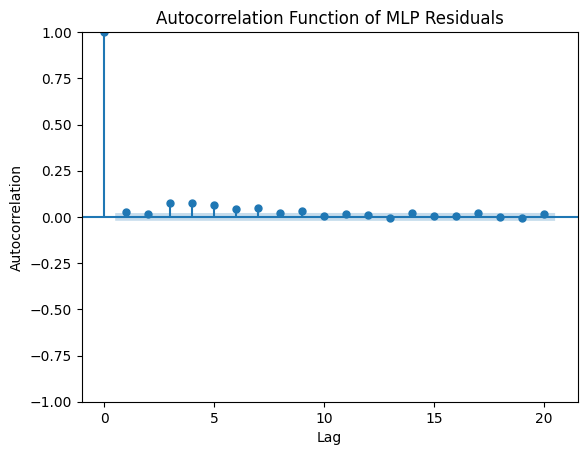

MAE      RMAE
horizonte 1h  0.067487  0.100317

In [29]:
df_GRU_one_error = pd.DataFrame(columns=['MAE','RMAE'])

horizonte = 1
df_test = prediccion(horizonte)

df_plot = pd.DataFrame()
df_plot['Time'] = df_test['Time']
df_plot['Prediction'] = df_test[f"horizonte {horizonte}"].values
df_plot['Power'] = df_test['Power'].values

fig = pl.line(df_plot, x='Time', y=['Power', 'Prediction'])
fig.show()

# Obtener residuos del modelo MLP
residuals = df_plot['Power'] - df_plot['Prediction']

# Calcular la función de autocorrelación de los residuos
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function of MLP Residuals')
plt.show()

df_GRU_one_error

# Comparación

In [23]:
df_resultados

+1h       +2h       +3h       +4h       +5h  \
2012-12-31 07:00:00  0.127418  0.106252  0.095118  0.092603  0.099109   
2012-12-31 08:00:00  0.081916  0.114934  0.097324  0.088340  0.084565   
2012-12-31 09:00:00  0.057365  0.076617  0.103094  0.089610  0.083445   
2012-12-31 10:00:00  0.055823  0.058193  0.072108  0.094450  0.082414   
2012-12-31 11:00:00  0.054238  0.057731  0.056281  0.069192  0.085086   
...                       ...       ...       ...       ...       ...   
2013-12-30 15:00:00 -0.040626 -0.020639 -0.001701  0.004805  0.025394   
2013-12-30 16:00:00 -0.030831 -0.033221 -0.008811 -0.007765  0.005453   
2013-12-30 17:00:00 -0.019206 -0.024434 -0.019870 -0.012036 -0.005266   
2013-12-30 18:00:00 -0.027962 -0.014403 -0.013530 -0.022147 -0.005546   
2013-12-30 19:00:00 -0.016867 -0.024470 -0.006120 -0.018083 -0.014130   

                          +6h       +7h       +8h       +9h      +10h  \
2012-12-31 07:00:00  0.068052  0.059166  0.083983  0.140528  0.139640   
2012-12-31 08:00:00  0.091431  0.062279  0.060220  0.092305  0.152026   
2012-12-31 09:00:00  0.080739  0.083286  0.057577  0.068151  0.096313   
2012-12-31 10:00:00  0.079631  0.074963  0.077855  0.059153  0.071732   
2012-12-31 11:00:00  0.077338  0.074643  0.073727  0.080639  0.059095   
...                       ...       ...       ...       ...       ...   
2013-12-30 15:00:00  0.027639  0.036651  0.044062  0.043091  0.043905   
2013-12-30 16:00:00  0.024021  0.030914  0.041849  0.053895  0.049542   
2013-12-30 17:00:00  0.003263  0.030207  0.035573  0.051921  0.063504   
2013-12-30 18:00:00 -0.005880  0.009662  0.035812  0.046214  0.060779   
2013-12-30 19:00:00 -0.003507  0.000834  0.013828  0.046694  0.054448   

                        Power  
2012-12-31 07:00:00  0.083451  
2012-12-31 08:00:00  0.065595  
2012-12-31 09:00:00  0.059581  
2012-12-31 10:00:00  0.052157  
2012-12-31 11:00:00  0.049995  
...                       ...  
2013-12-30 15:00:00  0.000000  
2013-12-30 16:00:00  0.000000  
2013-12-30 17:00:00  0.000000  
2013-12-30 18:00:00  0.000000  
2013-12-30 19:00:00  0.000000  

[8749 rows x 11 columns]

In [24]:
df_test

Time     Power  horizonte 5
8770  2012-12-31 11:00:00  0.065595     0.106151
8771  2012-12-31 12:00:00  0.059581     0.092420
8772  2012-12-31 13:00:00  0.052157     0.062764
8773  2012-12-31 14:00:00  0.049995     0.080908
8774  2012-12-31 15:00:00  0.056198     0.067461
...                   ...       ...          ...
17528 2013-12-31 09:00:00  0.079974     0.087464
17529 2013-12-31 10:00:00  0.074993     0.118936
17530 2013-12-31 11:00:00  0.076591     0.104776
17531 2013-12-31 12:00:00  0.044075     0.100185
17532 2013-12-31 13:00:00  0.142938     0.151223

[8763 rows x 3 columns]

In [25]:
horizonte_prediccion = 5
column_name = f'+{horizonte_prediccion}h'

df_plot = pd.DataFrame()
df_plot['Tiempo'] = df_resultados.index
df_plot['Many to Many'] = df_resultados[column_name].values
#df_plot['Many to One'] = df_test[f"horizonte {horizonte}"].values
df_plot['Producción Real'] = df_resultados['Power'].values

df_comp = df_plot[4:].copy()
df_comp['Many to One'] = df_test[:-18][f"horizonte {horizonte}"].values

fig = pl.line(df_comp, x='Tiempo', y=['Producción Real', 'Many to Many', 'Many to One'])
fig.show()